In [44]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [74]:
vehiculo = 'DA02'

In [75]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

117

In [76]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [77]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [78]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

3

In [79]:
contenido_filtrado

['2025-09-11 08-44-22.tlog',
 '2025-09-12 14-07-43.tlog',
 '2025-09-17 19-49-27.tlog']

In [80]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [81]:
lineas, names = leer_logs(contenido_filtrado)
lineas

[<LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (-62.809 -17.399, -62.809 -17.399, -62.809 -17.399, -62.809 -17....>]

In [82]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2025-09-11 08-44-22.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
1,2025-09-12 14-07-43.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
2,2025-09-17 19-49-27.tlog,"LINESTRING (-62.80915 -17.39876, -62.80915 -17..."


In [83]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [84]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [85]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [86]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-09-17 19-49-27.tlog,"LINESTRING (-62.80915 -17.39876, -62.80915 -17...",838,DA02
1,2025-09-17 19-49-27.tlog,"LINESTRING (-62.80914 -17.39876, -62.80914 -17...",597,DA02


<Axes: >

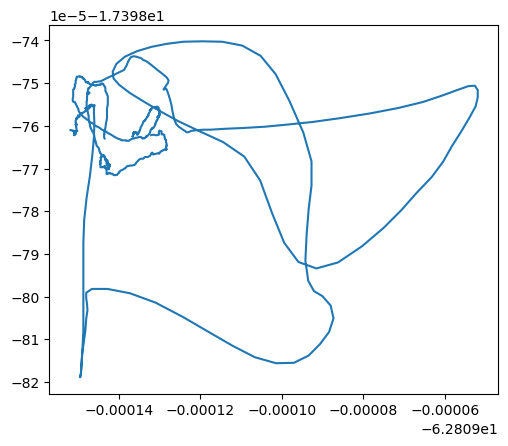

In [87]:
gdf_lines.plot()

In [88]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

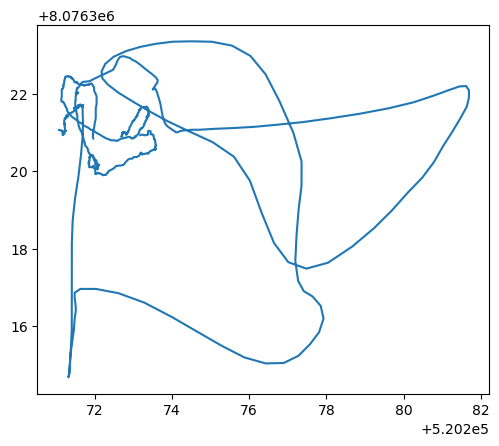

In [89]:
gdf_lines_utm.plot()

In [90]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [91]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2025-09-17 19-49-27.tlog,"LINESTRING (520271.049 8076321.081, 520271.081...",838,DA02,0
1,2025-09-17 19-49-27.tlog,"LINESTRING (520271.973 8076320.825, 520271.952...",597,DA02,0


In [92]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)

In [11]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

15

In [6]:
contenido_filtrado

['2025-09-17 20-54-19.tlog',
 '2025-09-17 21-09-53.tlog',
 '2025-09-17 21-14-21.tlog',
 '2025-09-17 21-14-48.tlog',
 '2025-09-17 21-20-20.tlog',
 '2025-09-17 21-21-33.tlog',
 '2025-09-17 22-00-19.tlog',
 '2025-09-17 23-22-51.tlog',
 '2025-09-17 23-29-32.tlog',
 '2025-09-17 23-51-32.tlog',
 '2025-09-18 02-12-08.tlog',
 '2025-09-18 03-43-30.tlog',
 '2025-09-18 03-44-04.tlog',
 '2025-09-18 03-54-25.tlog',
 '2025-09-18 03-54-48.tlog']

In [6]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [7]:
lineas, names = leer_logs(contenido_filtrado)
lineas

In [9]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2025-09-16 18-03-42.tlog,"LINESTRING (-62.83505 -17.41316, -62.83505 -17..."
1,2025-09-16 18-14-48.tlog,"LINESTRING (-62.83781 -17.40484, -62.83780 -17..."
2,2025-09-16 18-16-22.tlog,"LINESTRING (-62.83502 -17.41316, -62.83502 -17..."


<Axes: >

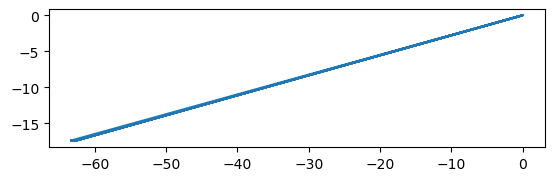

In [11]:
gdf_lines.plot()

In [12]:
#gdf_lines.to_file('LINEAS.shp', driver="ESRI Shapefile")

In [13]:
# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [14]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [15]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [17]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

<Axes: >

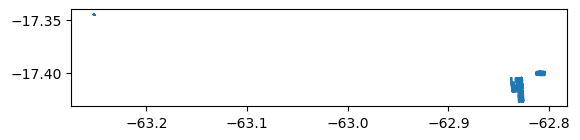

In [20]:
gdf_lines.plot()

In [21]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

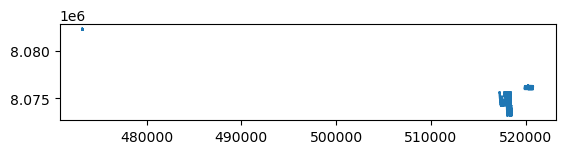

In [22]:
gdf_lines_utm.plot()

In [23]:
# Combinar los GeoDataFrames
gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_rec, gdf_lines_utm], ignore_index=True))
# rellenar valores NaN
gdf_combined['idd'] = gdf_combined['idd'].fillna(0).astype(int)

In [24]:
gdf_combined

,idd,nombre,vehiculo,num_vert,asignado,geometry
0,-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL,"LINESTRING (471873.745 8084797.248, 471873.415..."
1,-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL,"LINESTRING (478886.299 8093597.535, 478886.288..."
2,-1,2025-05-05 16-32-05.tlog,DA02,345.0,ORIGINAL,"LINESTRING (478939.004 8093577.919, 478939.004..."
3,-1,2025-05-05 21-05-04.tlog,DA02,3426.0,ORIGINAL,"LINESTRING (478661.660 8093836.724, 478660.405..."
4,-1,2025-05-05 21-05-04.tlog,DA02,3207.0,ORIGINAL,"LINESTRING (478649.523 8093832.840, 478649.555..."
...,...,...,...,...,...,...
575,0,2025-09-17 07-50-54.tlog,DA01,4110.0,NaN,"LINESTRING (520262.500 8076322.063, 520262.500..."
576,0,2025-09-17 07-50-54.tlog,DA01,177.0,NaN,"LINESTRING (520259.273 8076324.433, 520259.252..."
577,0,2025-09-17 07-50-54.tlog,DA01,341.0,NaN,"LINESTRING (520256.627 8076322.965, 520256.627..."
578,0,2025-09-17 07-50-54.tlog,DA01,148.0,NaN,"LINESTRING (520256.889 8076330.332, 520256.921..."


In [25]:
gdf_combined.dtypes

idd            int32
nombre        object
vehiculo      object
num_vert     float64
asignado      object
geometry    geometry
dtype: object

In [26]:
gdf_combined.to_file(path_rec, driver="ESRI Shapefile")

In [29]:
gdf_combined

,idd,nombre,vehiculo,num_vert,asignado,geometry
0,-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL,"LINESTRING (471873.745 8084797.248, 471873.415..."
1,-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL,"LINESTRING (478886.299 8093597.535, 478886.288..."
2,-1,2025-05-05 16-32-05.tlog,DA02,345.0,ORIGINAL,"LINESTRING (478939.004 8093577.919, 478939.004..."
3,-1,2025-05-05 21-05-04.tlog,DA02,3426.0,ORIGINAL,"LINESTRING (478661.660 8093836.724, 478660.405..."
4,-1,2025-05-05 21-05-04.tlog,DA02,3207.0,ORIGINAL,"LINESTRING (478649.523 8093832.840, 478649.555..."
...,...,...,...,...,...,...
575,0,2025-09-17 07-50-54.tlog,DA01,4110.0,NaN,"LINESTRING (520262.500 8076322.063, 520262.500..."
576,0,2025-09-17 07-50-54.tlog,DA01,177.0,NaN,"LINESTRING (520259.273 8076324.433, 520259.252..."
577,0,2025-09-17 07-50-54.tlog,DA01,341.0,NaN,"LINESTRING (520256.627 8076322.965, 520256.627..."
578,0,2025-09-17 07-50-54.tlog,DA01,148.0,NaN,"LINESTRING (520256.889 8076330.332, 520256.921..."
